In [61]:
import pandas as pd
import numpy as np
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
import math
warnings.filterwarnings('ignore')

In [62]:
# load transcriptional relationships for all genes
allgenes_CT_corr = pd.read_csv('results/expression_associations/all_genes_CT.csv')
allgenes_funcPC1_corr = pd.read_csv('results/expression_associations/all_genes_funcPC1.csv')

In [63]:
# function to conduct the permuation tests
def produce_permutation_sample(df,n_genes,n_perm):
    perm_r = []
    for i in range(n_perm):
        
        tmpdf = shuffle(df)
        tmp_mean_r = np.mean(tmpdf['r'].iloc[:n_genes].values)
        perm_r.append(tmp_mean_r)
    
    tmp = np.array(perm_r)
    return tmp
    
def compute_permutation(df,genes,n_perm):
    n_genes = len(genes)
    
    perm_sample = produce_permutation_sample(df,n_genes,n_perm)
    
    myvalue = np.mean(df.loc[genes]['r'].values)
    
    p1 = np.sum(perm_sample > myvalue)/n_perm
    p2 = np.sum(perm_sample < myvalue)/n_perm
    if p1 < p2:
        return p1*2,perm_sample
    else:
        return p2*2,perm_sample

In [64]:
#conduct the permutation test for genes differentially expressed in psychiatric disorders
allgenes_CT_corr1 = allgenes_CT_corr.set_index('genes')
allgenes_funcPC1_corr1 = allgenes_funcPC1_corr.set_index('genes')
Gandal_DGE = pd.read_csv('raw_data/Gandal_results.csv')
Gandal_traits = ['MDD','ASD','BD','SCZ']
n_perm = 5000

tmp_CT_correlations = []
tmp_CT_gene_sets = []
tmp_CT_perm_r = np.zeros((n_perm,2*len(Gandal_traits)))
tmp_CT_perm_p = np.zeros((2*len(Gandal_traits),1))

tmp_funcPC1_correlations = []
tmp_funcPC1_gene_sets = []
tmp_funcPC1_perm_r = np.zeros((n_perm,2*len(Gandal_traits)))
tmp_funcPC1_perm_p = np.zeros((2*len(Gandal_traits),1))

ordered_sets = []

for t in range(len(Gandal_traits)):
    trait = Gandal_traits[t]
    # select the differentially gene expression (DGE) values for a triat
    my_cols = ['exterl_gene_id',trait+'.beta_log2FC',trait+'.P.value',trait+'.FDR']
    my_DGE = Gandal_DGE[my_cols].dropna(how='any')
    my_DGE1 = my_DGE.set_index('exterl_gene_id')
    
    # select genes that are differentially expressed in a triat
    g = list(set(my_DGE1.index) & set(allgenes_CT_corr1.index))
    my_DGE2 = my_DGE1.loc[g]
    my_DGE2 = my_DGE2[my_DGE2[trait+'.FDR'] < 0.05]
    my_DGE_neg_genes = my_DGE2[my_DGE2[trait+'.beta_log2FC'] < 0].index.tolist()
    my_DGE_pos_genes = my_DGE2[my_DGE2[trait+'.beta_log2FC'] > 0].index.tolist()
    print(trait+' down-reg',len(my_DGE_neg_genes))
    print(trait+' up-reg',len(my_DGE_pos_genes))
    ordered_sets.append(trait+' down-reg'+' ('+'N='+str(len(my_DGE_neg_genes))+')')
    ordered_sets.append(trait+' up-reg'+' ('+'N='+str(len(my_DGE_pos_genes))+')')
    
    #Conduct permutation tests
    tmp_CT_perm_p[2*t,0],tmp_CT_perm_r[:,2*t] = compute_permutation(allgenes_CT_corr1,my_DGE_neg_genes,n_perm)
    tmp_CT_perm_p[2*t+1,0],tmp_CT_perm_r[:,2*t+1] = compute_permutation(allgenes_CT_corr1,my_DGE_pos_genes,n_perm)
    tmp_funcPC1_perm_p[2*t,0],tmp_funcPC1_perm_r[:,2*t] = compute_permutation(allgenes_funcPC1_corr1,my_DGE_neg_genes,n_perm)
    tmp_funcPC1_perm_p[2*t+1,0],tmp_funcPC1_perm_r[:,2*t+1] = compute_permutation(allgenes_funcPC1_corr1,my_DGE_pos_genes,n_perm)
    
    #create matrix to plot figures
    CT_neg_corr = allgenes_CT_corr1.loc[my_DGE_neg_genes]['r'].values.tolist()
    for i in range(len(my_DGE_neg_genes)):
        tmp_CT_correlations.append(CT_neg_corr[i])
        tmp_CT_gene_sets.append(trait+' down-reg'+' ('+'N='+str(len(my_DGE_neg_genes))+')')
    
    CT_pos_corr = allgenes_CT_corr1.loc[my_DGE_pos_genes]['r'].values.tolist()
    for i in range(len(my_DGE_pos_genes)):
        tmp_CT_correlations.append(CT_pos_corr[i])
        tmp_CT_gene_sets.append(trait+' up-reg'+' ('+'N='+str(len(my_DGE_pos_genes))+')')
        
    funcPC1_neg_corr = allgenes_funcPC1_corr1.loc[my_DGE_neg_genes]['r'].values.tolist()
    for i in range(len(my_DGE_neg_genes)):
        tmp_funcPC1_correlations.append(funcPC1_neg_corr[i])
        tmp_funcPC1_gene_sets.append(trait+' down-reg'+' ('+'N='+str(len(my_DGE_neg_genes))+')')
    
    funcPC1_pos_corr = allgenes_funcPC1_corr1.loc[my_DGE_pos_genes]['r'].values.tolist()
    for i in range(len(my_DGE_pos_genes)):
        tmp_funcPC1_correlations.append(funcPC1_pos_corr[i])
        tmp_funcPC1_gene_sets.append(trait+' up-reg'+' ('+'N='+str(len(my_DGE_pos_genes))+')')

# data to plot ridge figures
df_ridge_CT = pd.DataFrame(data=tmp_CT_correlations,columns=['corr'])
df_ridge_CT['row'] = tmp_CT_gene_sets
df_ridge_funcPC1 = pd.DataFrame(data=tmp_funcPC1_correlations,columns=['corr'])
df_ridge_funcPC1['row'] = tmp_funcPC1_gene_sets

# data to plot distribution figures
df_CT_perm_r = pd.DataFrame(data=tmp_CT_perm_r,columns=ordered_sets)
df_CT_perm_p = pd.DataFrame(data=tmp_CT_perm_p,columns=['perm_p'])
df_CT_perm_p['gene_sets'] = ordered_sets

df_funcPC1_perm_r = pd.DataFrame(data=tmp_funcPC1_perm_r,columns=ordered_sets)
df_funcPC1_perm_p = pd.DataFrame(data=tmp_funcPC1_perm_p,columns=['perm_p'])
df_funcPC1_perm_p['gene_sets'] = ordered_sets


MDD down-reg 110
MDD up-reg 40
ASD down-reg 1203
ASD up-reg 847
BD down-reg 236
BD up-reg 232
SCZ down-reg 1067
SCZ up-reg 719


In [65]:
#one sample t test to see whether the difference between mean correlations and 0 is significant
from scipy import stats
for geneset in ordered_sets:
    t,p = stats.ttest_1samp(df_ridge_CT[df_ridge_CT['row'] == geneset]['corr'].values, popmean=0)
    print(geneset,'CT',t,p)
    t,p = stats.ttest_1samp(df_ridge_funcPC1[df_ridge_funcPC1['row'] == geneset]['corr'].values, popmean=0)
    print(geneset,'funcPC1',t,p)

MDD down-reg (N=110) CT -2.16477282757947 0.03258644389495965
MDD down-reg (N=110) funcPC1 0.7421877632313049 0.4595699290844617
MDD up-reg (N=40) CT 1.90919140855336 0.06361466424798047
MDD up-reg (N=40) funcPC1 1.41800059053068 0.16413182945508903
ASD down-reg (N=1203) CT 0.6957526024178758 0.4867182705999358
ASD down-reg (N=1203) funcPC1 22.157589430262224 1.7215886044960615e-91
ASD up-reg (N=847) CT -0.49378983380992725 0.6215827836604293
ASD up-reg (N=847) funcPC1 -9.760490233574691 2.1290143034423605e-21
BD down-reg (N=236) CT -3.752518829447797 0.00022062659123757024
BD down-reg (N=236) funcPC1 10.859804868857253 1.572831530745171e-22
BD up-reg (N=232) CT -3.4903564663669058 0.0005776519498992882
BD up-reg (N=232) funcPC1 -9.658270842979926 9.360328990765648e-19
SCZ down-reg (N=1067) CT -1.8996271631725932 0.05775175832188117
SCZ down-reg (N=1067) funcPC1 22.87654816105791 1.4958816242157246e-94
SCZ up-reg (N=719) CT -8.532383123642783 8.479458743921619e-17
SCZ up-reg (N=719) fu

In [8]:
# function to plot the permuation test
def plot_permutation_test(df_perm,df_ridge,geneset_sizes,mytype,output_path):
    
    n_perm = df_perm.shape[0]
    thr1 = int(0.005*n_perm)
    thr2 = int(0.995*n_perm)
    mylabels = list(dict.fromkeys(df_ridge_CT['row'].values.tolist()))
    
    palette = sns.color_palette("husl", 9)
    palette[5] = palette[8]
    n_geneset = len(mylabels)
    for i in range(n_geneset):
        sns.set_theme(style="ticks")
        fig = plt.figure(figsize=(12,6))
        X = df_perm.iloc[:,i].values
        ax = sns.distplot(X, kde=True, hist=None,kde_kws={"linewidth": 3, 'color':palette[i]})

        X = np.sort(X)
        tmp_t1 = X[thr1]
        tmp_t2 = X[thr2]

        l = ax.lines[0]
        lx = l.get_xydata()[:,0]
        ly = l.get_xydata()[:,1]
        ax.fill_between(lx, ly, color=palette[i])
        
        t1 = np.where(lx > tmp_t2)[0][0]
        lx1 = lx[t1:]
        ly1 = ly[t1:]
        ax.fill_between(lx1, ly1, color="gray")
        ax.axvline(x=lx1[0], ymin=0, ymax=0.5, color='gray', linestyle='--',linewidth=5)

        t2 = np.where(lx < tmp_t1)[0][-1]
        lx2 = lx[:t2]
        ly2 = ly[:t2]
        ax.fill_between(lx2, ly2, color="gray")
        ax.axvline(x=lx2[-1], ymin=0, ymax=0.5, color='gray', linestyle='--',linewidth=5)
        
        mylabel = mylabels[i]
        tmp_m = np.mean(df_ridge[df_ridge['row'] == mylabel]['corr'].values)
        ax.axvline(x=tmp_m, ymin=0, ymax=0.5, color='red', linestyle='-',linewidth=5)

        plt.tick_params(direction='out', length=8, width=5,labelsize=50)  
#         plt.title(mylabel+'(N='+str(geneset_sizes[i])+')',fontsize=50)
        plt.title(mylabel,fontsize=50)
        ymax = math.ceil(np.max(ly)/10) * 10
        ystep = int(ymax/2)
        plt.ylabel("")
        ax.set_yticks(np.arange(0,ymax+1,ystep))
        ax.set_yticklabels(np.arange(0,ymax+1,ystep), size = 50)

        ax.spines['top'].set_linewidth(5)
        ax.spines['bottom'].set_linewidth(5)
        ax.spines['left'].set_linewidth(5)
        ax.spines['right'].set_linewidth(5)
        output_file = output_path + mytype + '_'+mylabel+'.png'
        fig.savefig(output_file,dpi=300,bbox_inches = 'tight')
        plt.clf()

In [9]:
geneset_sizes = [110,40,1203,847,236,232,1067,719]
plot_permutation_test(df_CT_perm_r,df_ridge_CT,geneset_sizes,'CT','results/statistical_figures/DGE/')
plot_permutation_test(df_funcPC1_perm_r,df_ridge_funcPC1,geneset_sizes,'funcPC1','results/statistical_figures/DGE/')

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

In [10]:
# function to plot ridge figures
def plot_ridge(df_ridge,mytype,output_path):
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':4})
    palette = sns.color_palette("husl", 9)
    palette[5] = palette[8]
    g = sns.FacetGrid(df_ridge, palette=palette, row="row", hue="row", aspect=9, height=1.6)
    g.map_dataframe(sns.kdeplot, x="corr", fill=True, alpha=1)
    g.map_dataframe(sns.kdeplot, x="corr", color='black')
    def label(x, color,label):
        ax = plt.gca()
        ax.text(0, .1, label, color='black', fontsize=24,
                ha="left", va="center", transform=ax.transAxes)

    g.map(label, "row")
    g.fig.subplots_adjust(hspace=-.5)
    g.set_titles("")
    g.set(yticks=[], xlabel="Correlations")
    g.despine( left=True)
    mylabels = list(dict.fromkeys(df_ridge['row'].values.tolist()))
    mean_positions = []
    for i in range(len(mylabels)):
        mylabel = mylabels[i]
        tmp_m = np.mean(df_ridge[df_ridge['row'] == mylabel]['corr'].values)
        mean_positions.append(tmp_m)
    
    for i in range(len(g.axes.flat)):
#     for ax in g.axes.flat:
        ax = g.axes.flat[i]
        ax.axvline(x=0, color='gray', linestyle='-',linewidth=2)  
        ax.axvline(x=mean_positions[i], ymin=0, ymax=0.5, color="red", linestyle='-',linewidth=3)  
#     plt.title("Distribution of correlation coefficients for "+mytype,loc='center',fontsize=40)
    plt.tick_params(direction='out', length=8, width=4,labelsize=40)
    plt.xlabel("Correlations",fontsize=40)
    g.savefig(output_path,dpi=300,bbox_inches = 'tight')
    plt.clf()

In [11]:
plot_ridge(df_ridge_CT,'CT','results/statistical_figures/DGE/ridge_CT.png')
plot_ridge(df_ridge_funcPC1,'funcPC1','results/statistical_figures/DGE/ridge_funcPC1.png')

<Figure size 1036.8x921.6 with 0 Axes>

<Figure size 1036.8x921.6 with 0 Axes>

In [12]:
# Conduct the permuation test based on gene sets with same sizes
def compute_permutation_p(df,perm_sample,genes):
    myvalue = np.mean(df.loc[genes]['r'].values)
    n_perm = perm_sample.shape[0]
    p1 = np.sum(perm_sample > myvalue)/n_perm
    p2 = np.sum(perm_sample < myvalue)/n_perm
    if p1 < p2:
        return p1*2
    else:
        return p2*2

In [13]:
#function to plot the permuation test based on gene sets with same sizes
def plot_permutation_test2(df_perm,df_ridge,genesize,mytype,output_path):
    n_perm = df_perm.shape[0]
    thr1 = int(0.005*n_perm)
    thr2 = int(0.995*n_perm)
    mylabels = list(dict.fromkeys(df_ridge_CT['row'].values.tolist()))
    
    palette = sns.color_palette("husl", 9)
    palette[5] = palette[8]
    n_geneset = len(mylabels)
    
    sns.set_theme(style="ticks")
    fig = plt.figure(figsize=(12,6))
    X = df_perm
    ax = sns.distplot(X, kde=True, hist=None,kde_kws={"linewidth": 4}, color= "gray")
    
    X = np.sort(X)
    tmp_t1 = X[thr1]
    tmp_t2 = X[thr2]
        
    l = ax.lines[0]
    lx = l.get_xydata()[:,0]
    ly = l.get_xydata()[:,1]

        
    t1 = np.where(lx > tmp_t2)[0][0]
    lx1 = lx[t1:]
    ly1 = ly[t1:]
    ax.fill_between(lx1, ly1, color="gray")
#     ax.axvline(x=lx1[0], ymin=0, ymax=0.5, color='gray', linestyle='--',linewidth=5)

    t2 = np.where(lx < tmp_t1)[0][-1]
    lx2 = lx[:t2]
    ly2 = ly[:t2]
    ax.fill_between(lx2, ly2, color="gray")
#     ax.axvline(x=lx2[-1], ymin=0, ymax=0.5, color='gray', linestyle='--',linewidth=5)

    for i in range(n_geneset):
        mylabel = mylabels[i]
        tmp_m = np.mean(df_ridge[df_ridge['row'] == mylabel]['corr'].values)
        ax.axvline(x=tmp_m, ymin=0, ymax=0.5, color=palette[i], linestyle='-',linewidth=4)
        
    plt.ylabel("Density",fontsize=30)
    plt.xlabel("Average correlations",fontsize=30)
    
    plt.tick_params(direction='out', length=8, width=5,labelsize=30) 
    plt.yticks(fontsize=30)
#     ax.set_yticks(np.arange(0,30.1,10))
#     ax.set_yticklabels(ax.get_yticklabels(), size = 30)
    
    plt.title("Permutation test for "+ mytype + ' (N='+str(genesize)+')',fontsize=30)
    ax.spines['top'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
    ax.spines['right'].set_linewidth(3)
    output_file = output_path + mytype + '_permutation_test_'+str(genesize)+'.png'
    fig.savefig(output_file,dpi=300,bbox_inches = 'tight')
    plt.clf()

In [72]:
allgenes_CT_corr1 = allgenes_CT_corr.set_index('genes')
allgenes_funcPC1_corr1 = allgenes_funcPC1_corr.set_index('genes')
Gandal_DGE = pd.read_csv('raw_data/Gandal_results.csv')
Gandal_traits = ['MDD','ASD','BD','SCZ']
n_perm = 5000
genesizes = [100,200,300,400,500,600,700,800]
for genesize in genesizes:

    tmp_CT_correlations = []
    tmp_CT_gene_sets = []
    # tmp_CT_perm_r = np.zeros((n_perm,2*len(Gandal_traits)))
    tmp_CT_perm_p = np.zeros((2*len(Gandal_traits),1))

    tmp_funcPC1_correlations = []
    tmp_funcPC1_gene_sets = []
    # tmp_funcPC1_perm_r = np.zeros((n_perm,2*len(Gandal_traits)))
    tmp_funcPC1_perm_p = np.zeros((2*len(Gandal_traits),1))

    ordered_sets = []

    perm_sample_CT = produce_permutation_sample(allgenes_CT_corr1,genesize,n_perm)
    perm_sample_funcPC1 = produce_permutation_sample(allgenes_funcPC1_corr1,genesize,n_perm)

    for t in range(len(Gandal_traits)):
        trait = Gandal_traits[t]
        my_cols = ['exterl_gene_id',trait+'.beta_log2FC',trait+'.P.value',trait+'.FDR']
        my_DGE = Gandal_DGE[my_cols].dropna(how='any')
        my_DGE1 = my_DGE.set_index('exterl_gene_id')
        g = list(set(my_DGE1.index) & set(allgenes_CT_corr1.index))

        my_DGE2 = my_DGE1.loc[g]
        my_DGE2 = my_DGE2[my_DGE2[trait+'.P.value'] < 0.05]
        my_DGE2 = my_DGE2.sort_values(by = [trait+'.beta_log2FC'])
        my_DGE_neg_genes = my_DGE2.iloc[:genesize,:].index.tolist()
        my_DGE_pos_genes = my_DGE2.iloc[-1*genesize:,:].index.tolist()

        ordered_sets.append(trait+' down-reg')
        ordered_sets.append(trait+' up-reg')


        tmp_CT_perm_p[2*t,0] = compute_permutation_p(allgenes_CT_corr1,perm_sample_CT,my_DGE_neg_genes)
        tmp_CT_perm_p[2*t+1,0] = compute_permutation_p(allgenes_CT_corr1,perm_sample_CT,my_DGE_pos_genes)

        tmp_funcPC1_perm_p[2*t,0] = compute_permutation_p(allgenes_funcPC1_corr1,perm_sample_funcPC1,my_DGE_neg_genes)
        tmp_funcPC1_perm_p[2*t+1,0] = compute_permutation_p(allgenes_funcPC1_corr1,perm_sample_funcPC1,my_DGE_pos_genes)

        CT_neg_corr = allgenes_CT_corr1.loc[my_DGE_neg_genes]['r'].values.tolist()
        for i in range(len(my_DGE_neg_genes)):
            tmp_CT_correlations.append(CT_neg_corr[i])
            tmp_CT_gene_sets.append(trait+' down-reg')


        CT_pos_corr = allgenes_CT_corr1.loc[my_DGE_pos_genes]['r'].values.tolist()
        for i in range(len(my_DGE_pos_genes)):
            tmp_CT_correlations.append(CT_pos_corr[i])
            tmp_CT_gene_sets.append(trait+' up-reg')

        funcPC1_neg_corr = allgenes_funcPC1_corr1.loc[my_DGE_neg_genes]['r'].values.tolist()
        for i in range(len(my_DGE_neg_genes)):
            tmp_funcPC1_correlations.append(funcPC1_neg_corr[i])
            tmp_funcPC1_gene_sets.append(trait+' down-reg')

        funcPC1_pos_corr = allgenes_funcPC1_corr1.loc[my_DGE_pos_genes]['r'].values.tolist()
        for i in range(len(my_DGE_pos_genes)):
            tmp_funcPC1_correlations.append(funcPC1_pos_corr[i])
            tmp_funcPC1_gene_sets.append(trait+' up-reg')

    df_ridge_CT = pd.DataFrame(data=tmp_CT_correlations,columns=['corr'])
    df_ridge_CT['row'] = tmp_CT_gene_sets

    df_ridge_funcPC1 = pd.DataFrame(data=tmp_funcPC1_correlations,columns=['corr'])
    df_ridge_funcPC1['row'] = tmp_funcPC1_gene_sets
    
    for geneset in ordered_sets:
        t,p = stats.ttest_1samp(df_ridge_CT[df_ridge_CT['row'] == geneset]['corr'].values, popmean=0)
        print(genesize,geneset,'CT',t,p)
        t,p = stats.ttest_1samp(df_ridge_funcPC1[df_ridge_funcPC1['row'] == geneset]['corr'].values, popmean=0)
        print(genesize,geneset,'funcPC1',t,p)


    # df_CT_perm_r = pd.DataFrame(data=tmp_CT_perm_r,columns=ordered_sets)
    df_CT_perm_p = pd.DataFrame(data=tmp_CT_perm_p,columns=['perm_p'])
    df_CT_perm_p['gene_sets'] = ordered_sets

    # df_funcPC1_perm_r = pd.DataFrame(data=tmp_funcPC1_perm_r,columns=ordered_sets)
    df_funcPC1_perm_p = pd.DataFrame(data=tmp_funcPC1_perm_p,columns=['perm_p'])
    df_funcPC1_perm_p['gene_sets'] = ordered_sets

    plot_ridge(df_ridge_CT,'CT','results/statistical_figures/DGE/ridge_CT_'+str(genesize)+'.png')
    plot_ridge(df_ridge_funcPC1,'funcPC1','results/statistical_figures/DGE/ridge_funcPC1_'+str(genesize)+'.png')

    plot_permutation_test2(perm_sample_CT,df_ridge_CT,genesize,'CT','results/statistical_figures/DGE/')
    plot_permutation_test2(perm_sample_funcPC1,df_ridge_funcPC1,genesize,'funcPC1','results/statistical_figures/DGE/')

100 MDD down-reg CT -3.0974169035372685 0.0025402800295295535
100 MDD down-reg funcPC1 -0.6873974078405849 0.49343957391619153
100 MDD up-reg CT 1.8813019287835526 0.06286907643470536
100 MDD up-reg funcPC1 0.7753107425897418 0.4400040873311749
100 ASD down-reg CT -1.4021781974668515 0.16398986224609302
100 ASD down-reg funcPC1 6.127369541139959 1.8219694370454762e-08
100 ASD up-reg CT -1.9995726182964826 0.04828665444454384
100 ASD up-reg funcPC1 -4.284832445445521 4.24475624716202e-05
100 BD down-reg CT -1.6089106141290614 0.11082030009201269
100 BD down-reg funcPC1 4.493891737000472 1.8996372497272477e-05
100 BD up-reg CT -11.045176374192827 5.828317246000117e-19
100 BD up-reg funcPC1 -20.191515317654005 7.048235183339286e-37
100 SCZ down-reg CT -0.2923052991714098 0.7706649131629782
100 SCZ down-reg funcPC1 3.8685746337444575 0.00019613518011456452
100 SCZ up-reg CT -13.187555899468164 1.5823716265653825e-23
100 SCZ up-reg funcPC1 -10.843109711389149 1.5982703659647354e-18
200 MDD 

<Figure size 1036.8x921.6 with 0 Axes>

<Figure size 1036.8x921.6 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 1036.8x921.6 with 0 Axes>

<Figure size 1036.8x921.6 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 1036.8x921.6 with 0 Axes>

<Figure size 1036.8x921.6 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 1036.8x921.6 with 0 Axes>

<Figure size 1036.8x921.6 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 1036.8x921.6 with 0 Axes>

<Figure size 1036.8x921.6 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 1036.8x921.6 with 0 Axes>

<Figure size 1036.8x921.6 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 1036.8x921.6 with 0 Axes>

<Figure size 1036.8x921.6 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 1036.8x921.6 with 0 Axes>

<Figure size 1036.8x921.6 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

In [16]:
# FDR multiple comparison correction
from statsmodels.stats import multitest
def fdr_correction(data):
    Ps = multitest.multipletests(data,alpha=0.05,method='fdr_bh')
    return Ps[1]

In [17]:
perm_p = np.hstack((df_CT_perm_p['perm_p'].values,df_funcPC1_perm_p['perm_p'].values))
fdr_perm_p = fdr_correction(perm_p)

In [68]:
# conduct permuation tests for cell-specific genes
cells_gene_set = pd.read_csv('raw_data/cell_gene_set2.csv')

cell_names = []
genes = []
for i in range(cells_gene_set.shape[0]):
    tmp = cells_gene_set.iloc[i,0].split(',')
    cell_names.append(tmp[1])
    genes.append(tmp[0])

tmpdf = pd.DataFrame(data=cell_names,columns=['cells'])
tmpdf['genes'] = genes

new_cell_names = ['Neuro-In', 'Neuro-Ex', 'Astro','Micro', 'Oligo', 'Endo', 'OPC']

tmp_CT_correlations = []
tmp_CT_gene_sets = []
tmp_CT_perm_r = np.zeros((n_perm,len(new_cell_names)))
tmp_CT_perm_p = np.zeros((len(new_cell_names),1))

tmp_funcPC1_correlations = []
tmp_funcPC1_gene_sets = []
tmp_funcPC1_perm_r = np.zeros((n_perm,len(new_cell_names)))
tmp_funcPC1_perm_p = np.zeros((len(new_cell_names),1))

new_cell_names2 = []
geneset_sizes = []
for i in range(len(new_cell_names)):
    cell_type = new_cell_names[i]
    print(cell_type)
    tmpl = tmpdf[tmpdf['cells'] == cell_type]['genes'].values.tolist()
    
    l = list(set(tmpl) & set(allgenes_CT_corr1.index))
    geneset_sizes.append(len(l))
    new_cell_names2.append(cell_type+' ('+'N='+str(len(l))+')')
    tmp_CT_perm_p[i,0],tmp_CT_perm_r[:,i] = compute_permutation(allgenes_CT_corr1,l,n_perm) 
    tmp_funcPC1_perm_p[i,0],tmp_funcPC1_perm_r[:,i] = compute_permutation(allgenes_funcPC1_corr1,l,n_perm)
    
    CT_corr = allgenes_CT_corr1.loc[l]['r'].values.tolist()
    for j in range(len(l)):
        tmp_CT_correlations.append(CT_corr[j])
        tmp_CT_gene_sets.append(cell_type+' ('+'N='+str(len(l))+')')
        
    funcPC1_corr = allgenes_funcPC1_corr1.loc[l]['r'].values.tolist()
    for i in range(len(l)):
        tmp_funcPC1_correlations.append(funcPC1_corr[i])
        tmp_funcPC1_gene_sets.append(cell_type+' ('+'N='+str(len(l))+')')
        
df_ridge_CT = pd.DataFrame(data=tmp_CT_correlations,columns=['corr'])
df_ridge_CT['row'] = tmp_CT_gene_sets

df_ridge_funcPC1 = pd.DataFrame(data=tmp_funcPC1_correlations,columns=['corr'])
df_ridge_funcPC1['row'] = tmp_funcPC1_gene_sets


df_CT_perm_r = pd.DataFrame(data=tmp_CT_perm_r,columns=new_cell_names)
df_CT_perm_p = pd.DataFrame(data=tmp_CT_perm_p,columns=['perm_p'])
df_CT_perm_p['gene_sets'] = new_cell_names2

df_funcPC1_perm_r = pd.DataFrame(data=tmp_funcPC1_perm_r,columns=new_cell_names)
df_funcPC1_perm_p = pd.DataFrame(data=tmp_funcPC1_perm_p,columns=['perm_p'])
df_funcPC1_perm_p['gene_sets'] = new_cell_names2

Neuro-In
Neuro-Ex
Astro
Micro
Oligo
Endo
OPC


In [69]:
for mycell in new_cell_names2:
    t,p = stats.ttest_1samp(df_ridge_CT[df_ridge_CT['row'] == mycell]['corr'].values, popmean=0)
    print(mycell,'CT',t,p)
    t,p = stats.ttest_1samp(df_ridge_funcPC1[df_ridge_funcPC1['row'] == mycell]['corr'].values, popmean=0)
    print(mycell,'funcPC1',t,p)

Neuro-In (N=829) CT 4.514400757215675 7.269720547561446e-06
Neuro-In (N=829) funcPC1 5.04642457148806 5.535755235928491e-07
Neuro-Ex (N=1131) CT 3.2377377059533634 0.0012398429012006845
Neuro-Ex (N=1131) funcPC1 14.27956975358829 1.1874045368036882e-42
Astro (N=779) CT -13.58114166823028 7.415705627079173e-38
Astro (N=779) funcPC1 -17.09356053193474 7.371328552482909e-56
Micro (N=619) CT 0.1343273664401069 0.8931874476576936
Micro (N=619) funcPC1 2.4202371229781803 0.01579771300965794
Oligo (N=783) CT -5.845124656930039 7.4298741253795206e-09
Oligo (N=783) funcPC1 5.913651212190581 4.99831462355673e-09
Endo (N=841) CT -0.767204496328255 0.44317552002118543
Endo (N=841) funcPC1 -2.5033163084970025 0.0124923264176831
OPC (N=140) CT -2.0723087805030573 0.040084325822203136
OPC (N=140) funcPC1 -3.7347326926782647 0.0002733652955551407


In [21]:
plot_permutation_test(df_CT_perm_r,df_ridge_CT,geneset_sizes,'CT','results/statistical_figures/cell/')
plot_permutation_test(df_funcPC1_perm_r,df_ridge_funcPC1,geneset_sizes,'funcPC1','results/statistical_figures/cell/')

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

In [22]:
plot_ridge(df_ridge_CT,'CT','results/statistical_figures/cell/ridge_CT.png')
plot_ridge(df_ridge_funcPC1,'funcPC1','results/statistical_figures/cell/ridge_funcPC1.png')

<Figure size 1036.8x806.4 with 0 Axes>

<Figure size 1036.8x806.4 with 0 Axes>

In [23]:
cell_perm_p = np.hstack((df_CT_perm_p['perm_p'].values,df_funcPC1_perm_p['perm_p'].values))
fdr_cell_perm_p = fdr_correction(cell_perm_p)

In [25]:
# load GWAS for PC1 of four risky behaviors
sig_MAGMA_data = pd.read_csv('raw_data/GWAS_sig_genes.txt',sep='\t')
sig_genes = list(set(sig_MAGMA_data['symbol'].values.tolist()))
com_genes = list(set(allgenes_CT_corr1.index) & set(sig_genes))

In [27]:
GWAS_CT_perm_p,GWAS_CT_perm_r = compute_permutation(allgenes_CT_corr1,com_genes,n_perm)
print(GWAS_CT_perm_p)

0.0064


In [28]:
GWAS_funcPC1_perm_p,GWAS_funcPC1_perm_r = compute_permutation(allgenes_funcPC1_corr1,com_genes,n_perm)
print(GWAS_funcPC1_perm_p)

0.5616


In [31]:
sig_CT = allgenes_CT_corr[allgenes_CT_corr['fdr_p'] < 0.05]
sig_CT_pos = sig_CT[sig_CT['r'] > 0]
sig_CT_neg = sig_CT[sig_CT['r'] < 0]

sig_funcPC1 = allgenes_funcPC1_corr[allgenes_funcPC1_corr['fdr_p'] < 0.05]
sig_funcPC1_pos = sig_funcPC1[sig_funcPC1['r'] > 0]
sig_funcPC1_neg = sig_funcPC1[sig_funcPC1['r'] < 0]

CT_pos_genes = sig_CT_pos['genes'].values.tolist()
CT_neg_genes = sig_CT_neg['genes'].values.tolist()
funcPC1_pos_genes = sig_funcPC1_pos['genes'].values.tolist()
funcPC1_neg_genes = sig_funcPC1_neg['genes'].values.tolist()

In [74]:
print(len(CT_pos_genes),len(CT_neg_genes),len(funcPC1_pos_genes),len(funcPC1_neg_genes))

526 392 1323 785


In [38]:
def save_genes(gene_list,save_path):
    df = pd.DataFrame(data=gene_list)
    df.to_csv(save_path,index=False,header=None)

In [41]:
save_genes(CT_pos_genes,'results/expression_associations/gene_set/CT_pos_genes.txt')
save_genes(CT_neg_genes,'results/expression_associations/gene_set/CT_neg_genes.txt')
save_genes(funcPC1_pos_genes,'results/expression_associations/gene_set/funcPC1_pos_genes.txt')
save_genes(funcPC1_neg_genes,'results/expression_associations/gene_set/funcPC1_neg_genes.txt')

In [33]:
import gseapy as gp

In [34]:
candidate_genesets = ['KEGG_2021_Human','GO_Biological_Process_2021']

In [35]:
res = gp.enrichr(gene_list=funcPC1_pos_genes, gene_sets=candidate_genesets, format='png',\
                 outdir='results/expression_associations/gene_set/funcPC1_pos',organism='human',cutoff=0.05,figsize=(12,6))

res = gp.enrichr(gene_list=funcPC1_neg_genes, gene_sets=candidate_genesets, format='png',\
                 outdir='results/expression_associations/gene_set/funcPC1_neg',organism='human',cutoff=0.05,figsize=(12,6))

res = gp.enrichr(gene_list=CT_pos_genes, gene_sets=candidate_genesets, format='png',\
                 outdir='results/expression_associations/gene_set/CT_pos',organism='human',cutoff=0.05,figsize=(12,6))

res = gp.enrichr(gene_list=CT_neg_genes, gene_sets=candidate_genesets, format='png',\
                 outdir='results/expression_associations/gene_set/CT_neg',organism='human',cutoff=0.05,figsize=(12,6))


2023-03-20 15:56:07,120 Warning: No enrich terms using library KEGG_2021_Human when cutoff = 0.05
2023-03-20 15:56:10,413 Warning: No enrich terms using library GO_Biological_Process_2021 when cutoff = 0.05
2023-03-20 15:56:14,639 Warning: No enrich terms using library KEGG_2021_Human when cutoff = 0.05
2023-03-20 15:56:17,620 Warning: No enrich terms using library GO_Biological_Process_2021 when cutoff = 0.05
2023-03-20 15:56:21,467 Warning: No enrich terms using library KEGG_2021_Human when cutoff = 0.05


In [45]:
def plot_BP_KEGG_figure(data,ynames,sizes,xmax,xstep,mycolor,legend_lables,legend_pos,mytitle,figsize,output_file):
    sns.set_theme(style="ticks")
    items = data['Description'].values.tolist()
    qdata = -data['Log10(q)'].values
    genes_num = data['Count'].values
    
    point_sizes = []
    for i in range(genes_num.shape[0]):
        for j in range(len(sizes)):
            if genes_num[i] >= sizes[j]:
                point_sizes.append(900 - (j+1)*150)
                break
            if j == len(sizes) - 1: 
                point_sizes.append(900 - (j+2)*150)
                
    fig = plt.figure(figsize=figsize) 
    s1 = data.shape[0]
    x = np.arange(0,s1)
    new_items = []
    for i in range(s1):
        j = s1-i-1
        k1 = x[i]
        k2 = qdata[j]
        size = point_sizes[j]
        new_items.append(ynames[j])
        plt.scatter(k2, k1, s=size,c=mycolor,alpha='0.8')
    
    legend_sizes = list(set(point_sizes))
    legend_sizes.sort()
    for i in range(len(legend_sizes)): 
        legend_size = legend_sizes[i]
        y_text = 0.6*i
        plt.scatter(legend_pos[0], y_text, s=legend_size,c=mycolor,alpha='0.8')
        plt.text(legend_pos[1],y_text,legend_lables[i],horizontalalignment='left',\
                 verticalalignment='center',fontsize=25)

    plt.xlim([0,xmax])
    plt.xticks(np.arange(0, xmax+0.5, step=xstep),fontsize=25)
    plt.yticks(np.arange(0, s1, step=1),new_items,fontsize=25)
    plt.tick_params(direction='out', length=6, width=3)
    plt.xlabel('-log10($p_{FDR}$)',fontsize=25)
    plt.axvline(x=1.3, ymin=0, ymax = s1, linewidth=3, linestyle="--", color='dimgray')
    plt.title(mytitle,fontsize=25)
    ax = plt.gca()
    ax.spines['top'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
    ax.spines['right'].set_linewidth(3)
    
    plt.show()
    fig.savefig(output_file,dpi=300,bbox_inches = 'tight')

In [42]:
enrich_funcPC1_pos = pd.read_csv('results/expression_associations/gene_set/funcPC1_pos_metascape.csv')

In [51]:
enrich_items_funcPC1_pos = ['BP: mRNA metabolic process',
'BP: ncRNA processing',
'BP: cellular response to\nDNA damage stimulus',
'BP: protein modification by\nsmall protein conjugation',
'BP: histone modification',
'BP: intracellular protein transport',
'BP: regulation of cell cycle process',
'BP: mitotic cell cycle process',
'BP: mitochondrion organization',
'BP: regulation of translation',
'BP: peptide metabolic process',
'KEGG: Amyotrophic lateral sclerosis',
'BP: Golgi vesicle transport',
'BP: endomembrane system organization',
'BP: regulation of mRNA\nmetabolic process',
'BP: negative regulation of\ncellular component organization',
'BP: positive regulation of\ncatabolic process',
'BP: tRNA metabolic process',
'BP: regulation of histone modification',
'BP: autophagy']

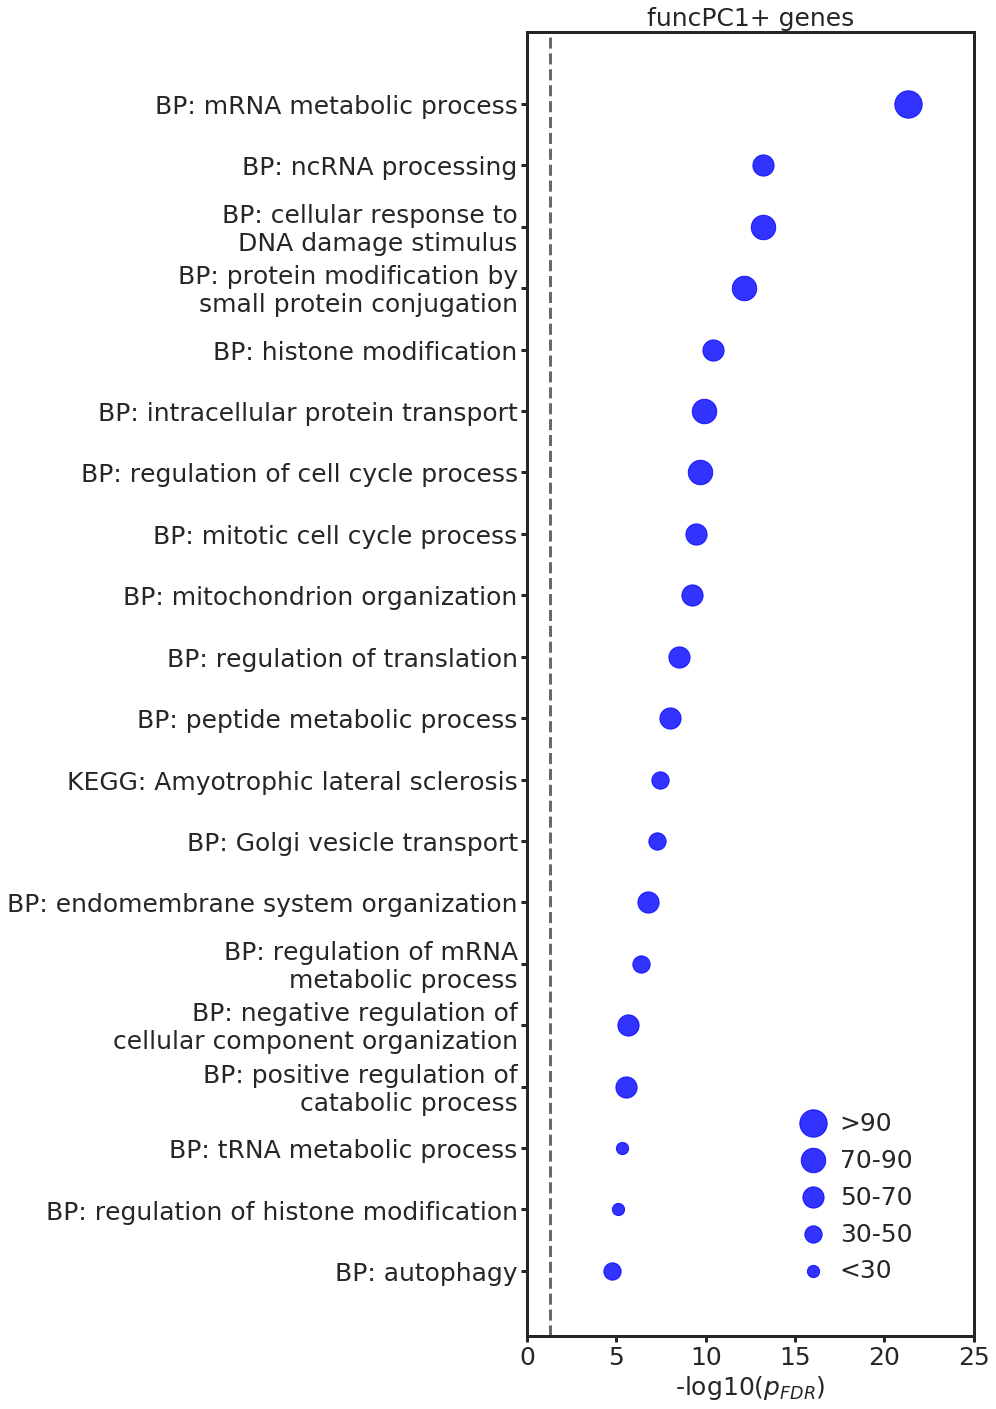

In [53]:
sizes = [90,70,50,30]
legend_labels = ['<30','30-50','50-70','70-90','>90']
plot_BP_KEGG_figure(enrich_funcPC1_pos,enrich_items_funcPC1_pos,sizes,25,5,'blue',legend_labels,[16,17.5],'funcPC1+ genes',(8,24),\
                    'results/expression_associations/gene_set/funcPC1_pos.png')

In [54]:
enrich_funcPC1_neg = pd.read_csv('results/expression_associations/gene_set/funcPC1_neg_metascape.csv')

In [59]:
enrich_items_funcPC1_neg = ['BP: forebrain development',
'BP: regulation of organelle assembly',
'BP: regulation of plasma membrane\nbounded cell projection organization',
'BP: blood vessel development',
'BP: positive regulation of\nprotein localization',
'BP: heart development',
'BP: positive regulation of\nphosphorylation',
'BP: cell morphogenesis involved\nin neuron differentiation',
'BP: intracellular protein transport',
'BP: membrane organization',
'BP: monocarboxylic acid\nmetabolic process',
'BP: endocytosis',
'BP: circulatory system process',
'BP: ameboidal-type cell migration',
'BP: enzyme-linked receptor\nprotein signaling pathway',
'BP: regulation of neuron death',
'BP: negative regulation of neuron\ndifferentiation',
'BP: synapse organization',
'BP: positive regulation of\nresponse to external stimulus',
'BP: positive regulation of exocytosis']

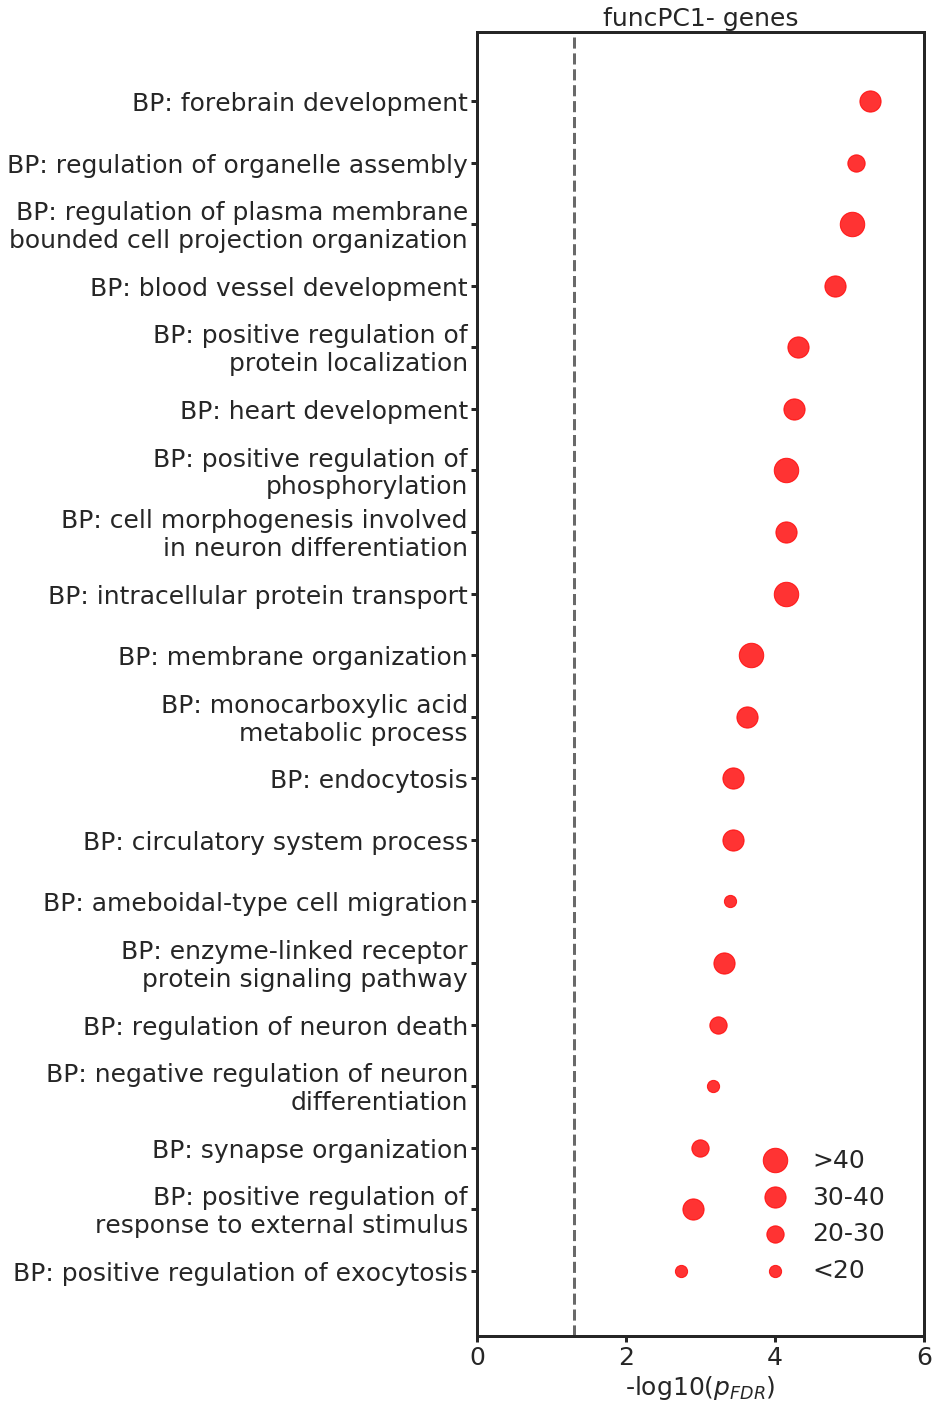

In [75]:
sizes = [50,40,30,20]
legend_labels = ['<20','20-30','30-40','>40','>50']
plot_BP_KEGG_figure(enrich_funcPC1_neg,enrich_items_funcPC1_neg,sizes,6,2,'red',legend_labels,[4,4.5],'funcPC1- genes',(8,24),\
                    'results/expression_associations/gene_set/funcPC1_neg.png')